In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
from datetime import timedelta

In [25]:
df = pd.read_csv('../92-Site_DKA-M6_B-Phase.csv')

In [26]:
print(df.describe())

       Active_Energy_Delivered_Received  Current_Phase_Average  Active_Power  \
count                      1.573221e+06           1.573214e+06  1.573214e+06   
mean                       7.172700e+04           4.685938e+00  1.084910e+00   
std                        4.171347e+04           6.099162e+00  1.531835e+00   
min                        0.000000e+00           0.000000e+00 -4.000000e-02   
25%                        3.568800e+04           3.000000e-01  0.000000e+00   
50%                        7.234600e+04           3.000000e-01  0.000000e+00   
75%                        1.077950e+05           9.446667e+00  2.295450e+00   
max                        1.433680e+05           2.366600e+01  5.824800e+00   

       Performance_Ratio     Wind_Speed  Weather_Temperature_Celsius  \
count      868887.000000  841771.000000                 1.567197e+06   
mean          222.533198       2.508527                 2.112727e+01   
std          2884.587762       4.362972                 9.88285

In [27]:
print(df.head())

             timestamp  Active_Energy_Delivered_Received  \
0  2008-09-12 05:55:00                               0.0   
1  2008-09-12 06:00:00                               0.0   
2  2008-09-12 06:05:00                               0.0   
3  2008-09-12 06:10:00                               0.0   
4  2008-09-12 06:15:00                               0.0   

   Current_Phase_Average  Active_Power  Performance_Ratio  Wind_Speed  \
0                    0.0           0.0                NaN         NaN   
1                    0.0           0.0                NaN         NaN   
2                    0.0           0.0                NaN         NaN   
3                    0.0           0.0                NaN         NaN   
4                    0.0           0.0                NaN         NaN   

   Weather_Temperature_Celsius  Weather_Relative_Humidity  \
0                    25.734350                  18.551216   
1                    25.402353                  19.242727   
2                

In [28]:
print(df.isnull().sum())

timestamp                                0
Active_Energy_Delivered_Received      1238
Current_Phase_Average                 1245
Active_Power                          1245
Performance_Ratio                   705572
Wind_Speed                          732688
Weather_Temperature_Celsius           7262
Weather_Relative_Humidity             7262
Global_Horizontal_Radiation           7263
Diffuse_Horizontal_Radiation          7263
Wind_Direction                        9421
Weather_Daily_Rainfall                7238
Radiation_Global_Tilted             611886
Radiation_Diffuse_Tilted            569759
dtype: int64


In [29]:
print(df.columns)

Index(['timestamp', 'Active_Energy_Delivered_Received',
       'Current_Phase_Average', 'Active_Power', 'Performance_Ratio',
       'Wind_Speed', 'Weather_Temperature_Celsius',
       'Weather_Relative_Humidity', 'Global_Horizontal_Radiation',
       'Diffuse_Horizontal_Radiation', 'Wind_Direction',
       'Weather_Daily_Rainfall', 'Radiation_Global_Tilted',
       'Radiation_Diffuse_Tilted'],
      dtype='object')


In [30]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

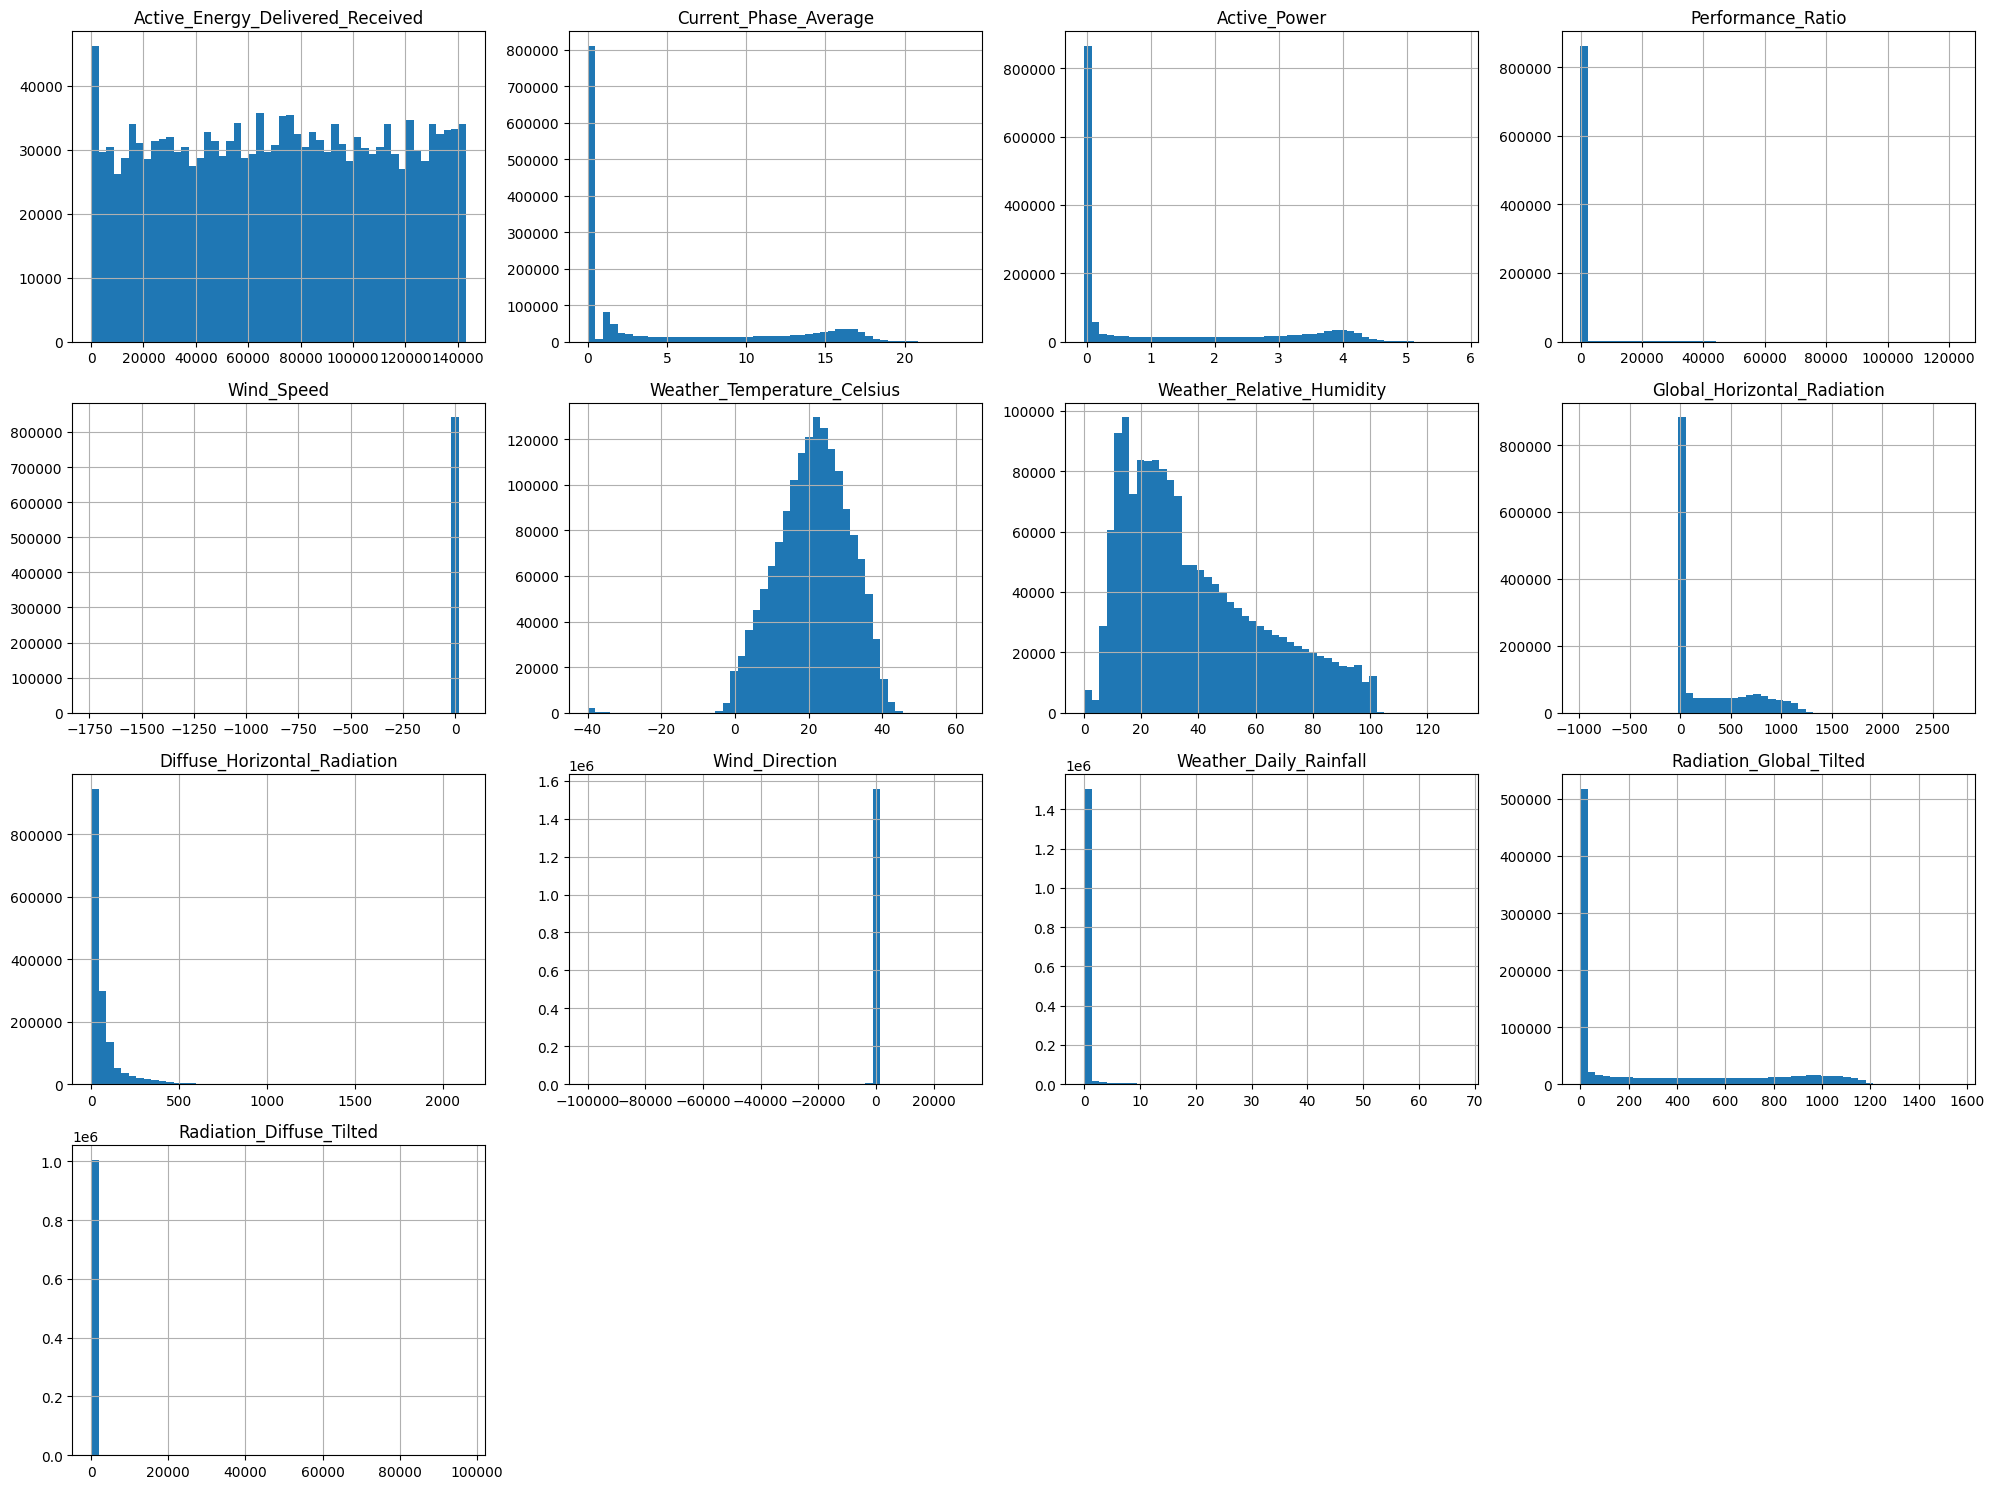

In [31]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    df[feature].hist(bins=50)
    plt.title(feature)

plt.tight_layout()
plt.show()

In [32]:
def clean_data(df):
    column_names = df.columns
    clean_names = [name.replace(' ', '_') for name in column_names] # remove any existing prefixes in column names
    df.columns = clean_names

    df.index = pd.to_datetime(df['timestamp']) # convert the timestamp column to a datetime index
    df.drop('timestamp', axis=1, inplace=True)

    df.fillna(0, inplace=True) # fill in any missing values with 0s

    new_index = pd.date_range(df.index.min(), df.index.max(), freq='5min') # create a consistent time series index and impute missing timestamps
    df_imputed = pd.DataFrame(index=new_index)
    df_imputed = df.asof(pd.DatetimeIndex(new_index))
    df_imputed.fillna(0, inplace=True)
    
    return df_imputed

In [33]:
cleaned_df = clean_data(df)
print(cleaned_df.head())

                     Active_Energy_Delivered_Received  Current_Phase_Average  \
2008-09-12 05:55:00                               0.0                    0.0   
2008-09-12 06:00:00                               0.0                    0.0   
2008-09-12 06:05:00                               0.0                    0.0   
2008-09-12 06:10:00                               0.0                    0.0   
2008-09-12 06:15:00                               0.0                    0.0   

                     Active_Power  Performance_Ratio  Wind_Speed  \
2008-09-12 05:55:00           0.0                0.0         0.0   
2008-09-12 06:00:00           0.0                0.0         0.0   
2008-09-12 06:05:00           0.0                0.0         0.0   
2008-09-12 06:10:00           0.0                0.0         0.0   
2008-09-12 06:15:00           0.0                0.0         0.0   

                     Weather_Temperature_Celsius  Weather_Relative_Humidity  \
2008-09-12 05:55:00            

### Time series methods

#### Deviation from the mean

Here we just classify any point that falls out of the range (3 standard deviations) as an anomaly.  

Another approach is get the mean average of each hour of the day (grouping the data by the hour and getting the mean), and then getting a sense of what the typical active power should be for each hour, and calculating confidence intervals (also based on the standard deviation for each hour) for the mean active power each hour.  Then we could classify anything outside of those confidence intervals of 99% as an anomaly.

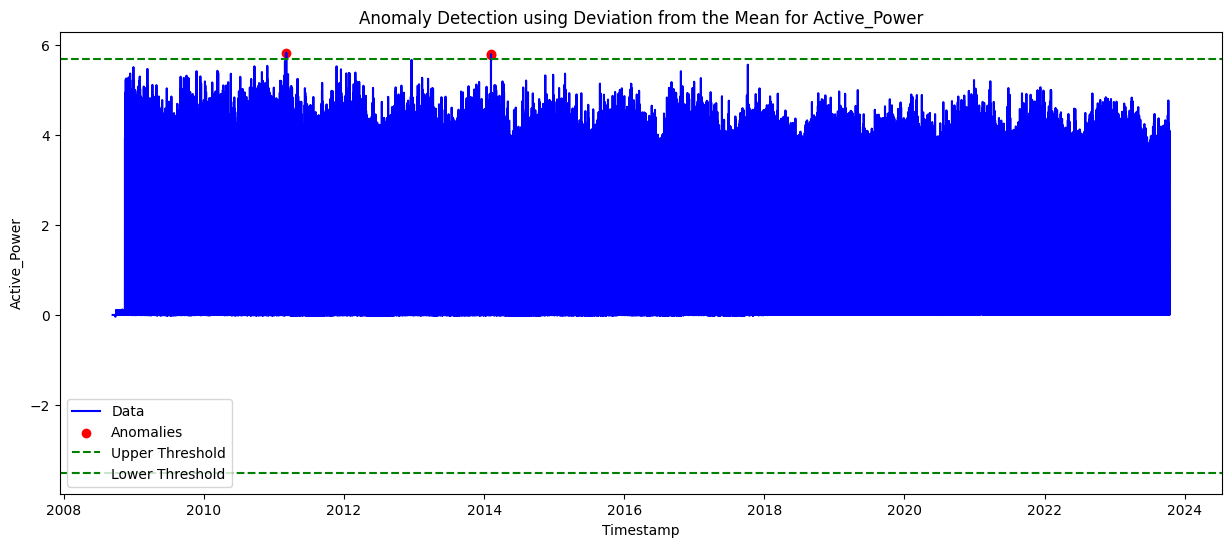

In [34]:
feature = 'Active_Power' # detect anomalies for the Active Power feature
data = cleaned_df[feature]

mean_value = np.mean(data)
std_value = np.std(data)

threshold = 3 * std_value # use 3 standard deviations as the threshold

anomalies = data[(data < mean_value - threshold) | (data > mean_value + threshold)]

plt.figure(figsize=(15, 6))
plt.plot(data.index, data, label='Data', color='blue')
plt.scatter(anomalies.index, anomalies, color='red', label='Anomalies')
plt.axhline(y=mean_value + threshold, color='g', linestyle='--', label='Upper Threshold')
plt.axhline(y=mean_value - threshold, color='g', linestyle='--', label='Lower Threshold')
plt.title(f"Anomaly Detection using Deviation from the Mean for {feature}")
plt.xlabel("Timestamp")
plt.ylabel(feature)
plt.legend()
plt.show()


### ML approaches

#### k-Nearest Neighbors (k-NN)

k-NN algorithm classifies a data point based upon how its neighbors are also classified.  To apply it to anomaly detection, we can classify a point as an anomaly if its distance to its kth nearest neighbor is above a certain threshold.

In [36]:
feature_data = cleaned_df[['Active_Power']].values # convert the feature column to a NumPy array for k-NN
feature_data = feature_data.reshape(-1, 1)

knn_model = NearestNeighbors(n_neighbors=5) # init model
knn_model.fit(feature_data)

distances, indices = knn_model.kneighbors(feature_data) # find the k-neighbors of each point

kth_distances = distances[:, 4] # calculate the distance to the kth nearest neighbor (k=5)

distance_threshold = 1.5 * np.mean(kth_distances) # use 1.5 times the mean as the threshold for anomalies

anomaly_indices = np.where(kth_distances > distance_threshold)[0] # Identify anomalies (points where the distance to the kth neighbor is greater than the threshold)
anomalies_knn = cleaned_df.iloc[anomaly_indices]

print(anomalies_knn.head()) 

k-NN is O(N) time and memory complexity for querying all the points, so this could take quite a long time

Might need to use an optimized algorithm like kd-tree or ball tree to reduce the query time to O(log N) for each point

Sampling doesn't seem appropriate here, since it would miss anomalies, but perhaps windowing and getting a sense of what it's like to apply k-NN to each window would be useful here

NameError: name 'anomalies_knn' is not defined

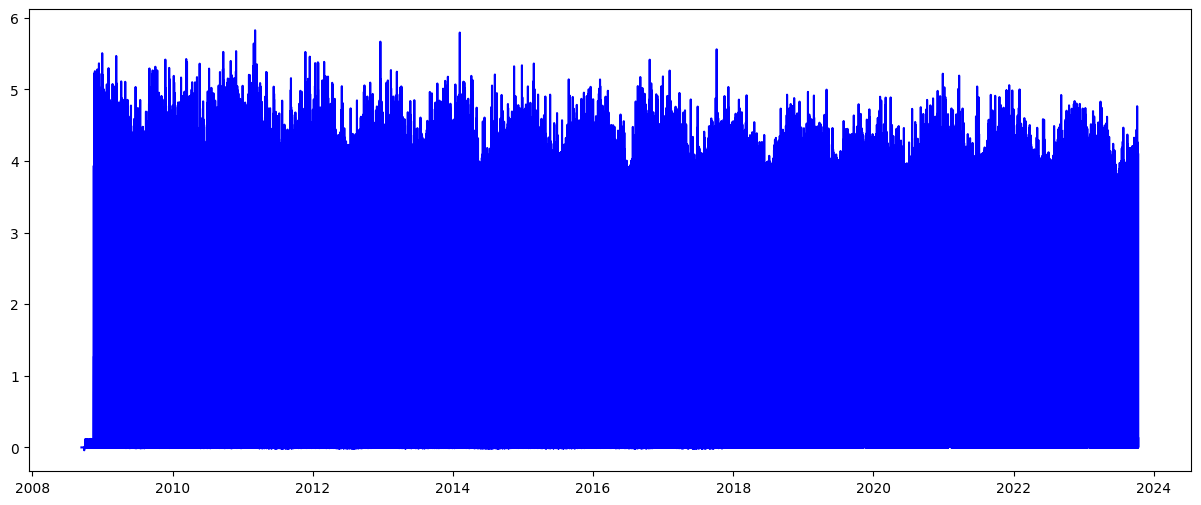

In [ ]:
# Plotting the data and anomalies
plt.figure(figsize=(15, 6))
plt.plot(cleaned_df.index, cleaned_df['Active_Power'], label='Data', color='blue')
plt.scatter(anomalies_knn.index, anomalies_knn['Active_Power'], color='red', label='Anomalies')
plt.title('k-NN Anomaly Detection for Active_Power')
plt.xlabel('Timestamp')
plt.ylabel('Active_Power')
plt.legend()
plt.show()

# Display anomalies
print(anomalies_knn.head())